Train files: 84000
Validation files: 18000
Test files: 18000
Epoch 1: Train Loss: 0.1926, Train Acc: 0.8458 | Val Loss: 0.1248, Val Acc: 0.8964 | Test Loss: 0.1245, Test Acc: 0.8963 | Time: 203.88s
Epoch 2: Train Loss: 0.1212, Train Acc: 0.9001 | Val Loss: 0.1050, Val Acc: 0.9146 | Test Loss: 0.1036, Test Acc: 0.9147 | Time: 202.31s
Epoch 3: Train Loss: 0.1051, Train Acc: 0.9131 | Val Loss: 0.0993, Val Acc: 0.9177 | Test Loss: 0.0975, Test Acc: 0.9187 | Time: 204.93s
Epoch 4: Train Loss: 0.0991, Train Acc: 0.9187 | Val Loss: 0.0870, Val Acc: 0.9268 | Test Loss: 0.0867, Test Acc: 0.9259 | Time: 204.49s
Epoch 5: Train Loss: 0.0960, Train Acc: 0.9210 | Val Loss: 0.0861, Val Acc: 0.9317 | Test Loss: 0.0865, Test Acc: 0.9292 | Time: 203.52s
Epoch 6: Train Loss: 0.0889, Train Acc: 0.9262 | Val Loss: 0.0854, Val Acc: 0.9303 | Test Loss: 0.0865, Test Acc: 0.9302 | Time: 205.24s
Epoch 7: Train Loss: 0.0845, Train Acc: 0.9301 | Val Loss: 0.0753, Val Acc: 0.9382 | Test Loss: 0.0762, Test Acc: 0.9

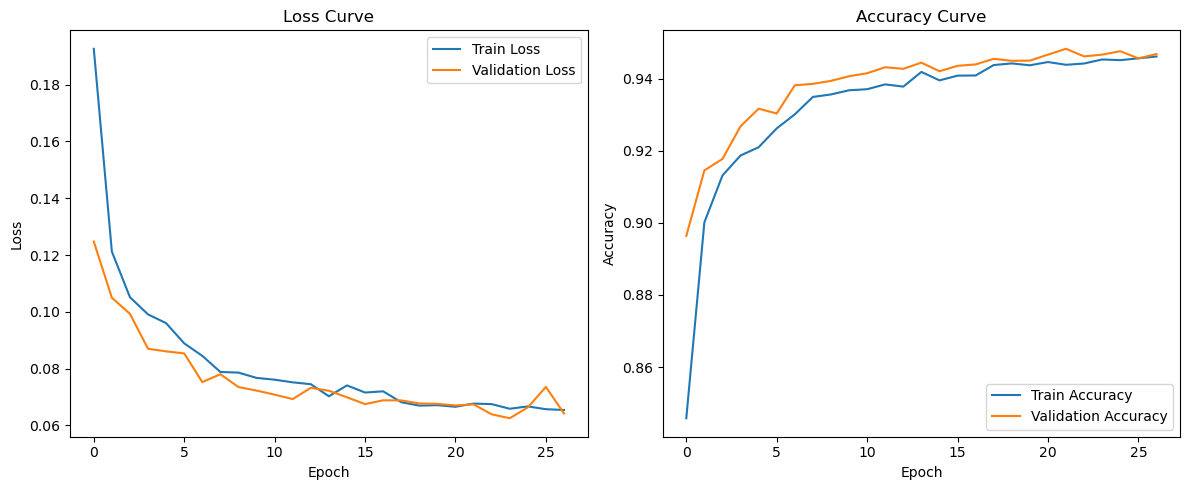

In [1]:
import os
import glob
import numpy as np
import torch
import torchaudio
import torchaudio.transforms as T
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import OneCycleLR
from torch.cuda.amp import GradScaler, autocast
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings("ignore")

# Define paths and classes
data_path = "/home/chetak/Speech_Mixing/Clean+Noise Augmented Speech"
snr_folders = ["SNR_-5", "SNR_-3", "SNR_0", "SNR_3", "SNR_5", "SNR_10"]
classes = {"Airport": 0, "Babble": 1, "Resturant": 2, "Station": 3}

# Load data
def load_data(dataset_path, snr_folders):
    audio_files, labels = [], []
    for snr in snr_folders:
        for class_name, label in classes.items():
            class_path = os.path.join(dataset_path, class_name, snr)
            files = glob.glob(os.path.join(class_path, "*.wav"))
            audio_files.extend(files)
            labels.extend([label] * len(files))
    return audio_files, labels

all_files, all_labels = load_data(data_path, snr_folders)
# Split data into 70% training, 15% validation, and 15% testing
train_files, test_files, train_labels, test_labels = train_test_split(all_files, all_labels, test_size=0.30, stratify=all_labels, random_state=42)
val_files, test_files, val_labels, test_labels = train_test_split(test_files, test_labels, test_size=0.50, stratify=test_labels, random_state=42)

print("Train files:", len(train_files))
print("Validation files:", len(val_files))
print("Test files:", len(test_files))

# Custom Dataset
class AudioDataset(Dataset):
    def __init__(self, file_list, labels, fixed_length=128):
        self.file_list = file_list
        self.labels = labels
        self.fixed_length = fixed_length
        self.mel_transform = T.MelSpectrogram(sample_rate=8000, n_fft=512, hop_length=256, n_mels=128)
        self.db_transform = T.AmplitudeToDB()
    
    def __getitem__(self, idx):
        file_path = self.file_list[idx]
        label = self.labels[idx]
        waveform, _ = torchaudio.load(file_path)
        mel_spec = self.mel_transform(waveform).squeeze(0)
        mel_spec = self.db_transform(mel_spec)  # Convert to dB scale

        # Clamp spectrogram before log
        mel_spec = torch.clamp(mel_spec, min=1e-5)
        mel_spec = torch.log1p(mel_spec)

        # Ensure consistent shape
        if mel_spec.shape[1] < self.fixed_length:
            mel_spec = F.pad(mel_spec, (0, self.fixed_length - mel_spec.shape[1]))
        else:
            mel_spec = mel_spec[:, :self.fixed_length]

        # Ensure no silent spectrograms
        if mel_spec.sum() == 0:
            mel_spec += torch.randn_like(mel_spec) * 1e-5  # Add small noise

        return mel_spec, label
    
    def __len__(self):
        return len(self.file_list)

# Focal Loss Implementation
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')  # Cross-entropy loss
        pt = torch.exp(-ce_loss)  # Softmax probability
        focal_loss = (1 - pt) ** self.gamma * ce_loss  # Focal loss formula

        if self.alpha is not None:
            focal_loss = self.alpha[targets] * focal_loss  # Apply class weights

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# PatchAST Model
class PatchASTModel(nn.Module):
    def __init__(self, num_classes=4, embed_dim=512, num_heads=4, num_layers=6, dropout=0.2):
        super().__init__()
        self.patch_embedding = nn.Linear(128, embed_dim)
        self.batch_norm = nn.BatchNorm1d(128, eps=1e-5)
        self.positional_encoding = nn.Parameter(torch.zeros(1, 128, embed_dim))
        self.dropout = nn.Dropout(dropout)
        self.transformer_layers = nn.ModuleList([
            nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, batch_first=True)
            for _ in range(num_layers)
        ])
        self.layer_norm = nn.LayerNorm(embed_dim)
        self.attention_pooling = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout)
        self.fc = nn.Linear(embed_dim, num_classes)
        
        # Xavier Initialization
        nn.init.xavier_uniform_(self.patch_embedding.weight)
        nn.init.zeros_(self.patch_embedding.bias)
        nn.init.xavier_uniform_(self.fc.weight)
        nn.init.zeros_(self.fc.bias)
    
    def forward(self, x):
        x = x.permute(0, 2, 1)  # (batch, 128, time) -> (batch, time, 128)
        x = self.patch_embedding(x)
        x = self.batch_norm(x)
        x = F.gelu(x)  # Apply GeLU after batch normalization
        x = x + self.positional_encoding[:, :x.size(1), :]
        x = self.dropout(x)
        
        for layer in self.transformer_layers:
            x = layer(x)
            x = self.layer_norm(x)  # Layer normalization before activation
        
        # Attention Pooling
        x = x.permute(1, 0, 2)  # (batch, time, embed) -> (time, batch, embed)
        x, _ = self.attention_pooling(x, x, x)
        x = x.mean(dim=0)  # Global average pooling
        
        return self.fc(x)  # Final classification

# Evaluate Function
def evaluate(model, data_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss, total_correct, total_samples = 0, 0, 0
    
    with torch.no_grad():  # Disable gradient computation
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Accumulate metrics
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)
    
    # Compute average loss and accuracy
    avg_loss = total_loss / len(data_loader)
    accuracy = total_correct / total_samples
    return avg_loss, accuracy

# Training Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(all_labels), y=all_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

# Initialize model, criterion, optimizer, and scheduler
model = PatchASTModel(num_classes=len(classes)).to(device)
criterion = FocalLoss(alpha=class_weights, gamma=2.0)  # Focal Loss with class weights
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-3)  # Adjusted weight decay

# Data Loaders
train_dataset = AudioDataset(train_files, train_labels)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)

val_dataset = AudioDataset(val_files, val_labels)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

test_dataset = AudioDataset(test_files, test_labels)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

# OneCycleLR Scheduler
scheduler = OneCycleLR(optimizer, max_lr=3e-4, steps_per_epoch=len(train_loader), epochs=500, pct_start=0.3)
scaler = GradScaler()  # For mixed precision training

# Training Loop with Early Stopping
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
best_val_accuracy = 0.0
patience = 5  # Number of epochs to wait for improvement
epochs_without_improvement = 0

for epoch in range(500):  # Train for 500 epochs
    model.train()
    train_loss, train_correct, train_total = 0, 0, 0
    start_time = time.time()
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        with autocast():  # Mixed precision training
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.1)  # Lower max_norm for stability
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()  # Update learning rate
        
        # Accumulate training metrics
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_correct += (predicted == labels).sum().item()
        train_total += labels.size(0)
    
    # Evaluate on validation set
    val_loss, val_accuracy = evaluate(model, val_loader, criterion)
    
    # Evaluate on test set
    test_loss, test_accuracy = evaluate(model, test_loader, criterion)
    
    # Save the best model
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), "best_model.pth")
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
    
    # Store metrics for plotting
    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(train_correct / train_total)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    # Print metrics
    epoch_time = time.time() - start_time
    print(f"Epoch {epoch + 1}: "
          f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f} | "
          f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f} | "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.4f} | "
          f"Time: {epoch_time:.2f}s")
    
    # Early stopping
    if epochs_without_improvement >= patience:
        print(f"Early stopping at epoch {epoch + 1}")
        break

# Load the best model for final evaluation
model.load_state_dict(torch.load("best_model.pth"))

# Final evaluation on test set
test_loss, test_accuracy = evaluate(model, test_loader, criterion)
print(f"Final Test Loss: {test_loss:.4f}, Final Test Accuracy: {test_accuracy:.4f}")

# Plot Accuracy and Loss Curves
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()

plt.tight_layout()
plt.show()

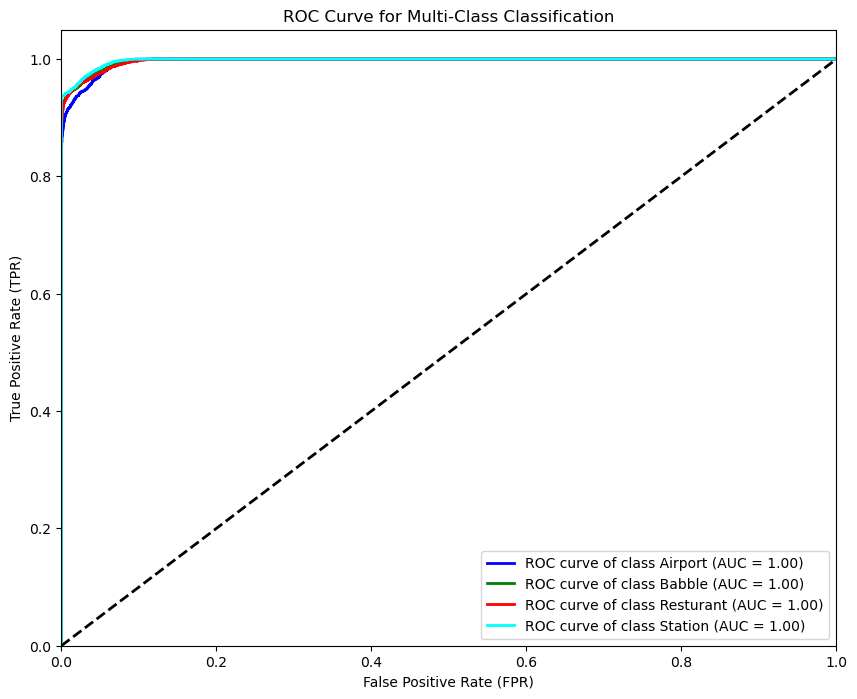

In [2]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Load the best model
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

# Collect predictions and true labels
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        probs = F.softmax(outputs, dim=1)  # Convert logits to probabilities
        all_preds.append(probs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Concatenate predictions and labels
all_preds = np.concatenate(all_preds, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Binarize the labels for multi-class ROC
n_classes = len(classes)  # Use the `classes` dictionary to get the number of classes
true_labels_binarized = label_binarize(all_labels, classes=range(n_classes))

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels_binarized[:, i], all_preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for all classes
plt.figure(figsize=(10, 8))
colors = ['blue', 'green', 'red', 'cyan']

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {list(classes.keys())[i]} (AUC = {roc_auc[i]:.2f})')

# Plot the diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend(loc="lower right")
plt.savefig("roc_curve.png")  # Save the plot
plt.show()

Classification Report:
              precision    recall  f1-score   support

     Airport       0.86      0.97      0.91      4500
      Babble       0.96      0.94      0.95      4500
   Resturant       0.98      0.93      0.96      4500
     Station       1.00      0.94      0.97      4500

    accuracy                           0.95     18000
   macro avg       0.95      0.95      0.95     18000
weighted avg       0.95      0.95      0.95     18000



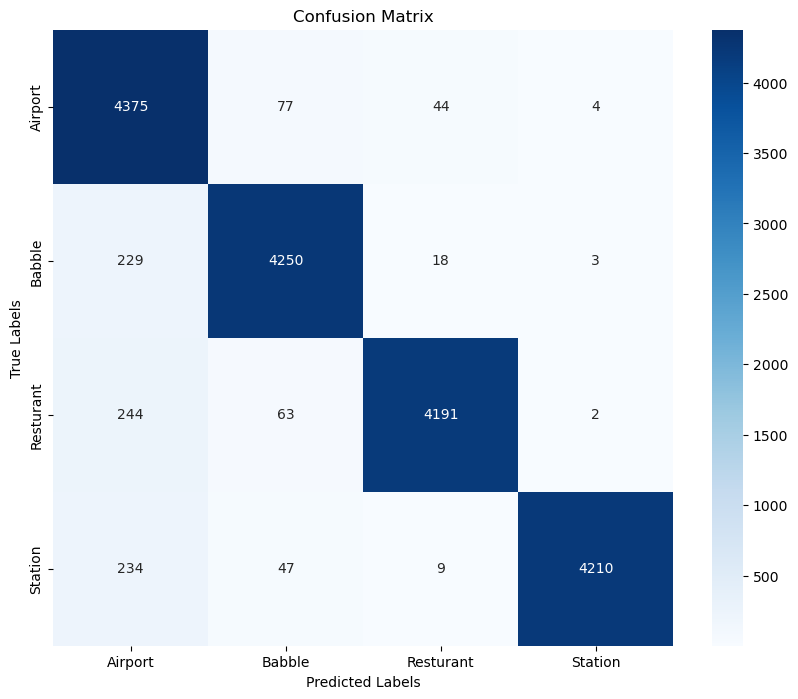

In [3]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load the best model
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

# Collect predictions and true labels
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)  # Get predicted class labels
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert lists to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Generate classification report
class_names = list(classes.keys())  # Get class names from the `classes` dictionary
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Generate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
#plt.savefig("confusion_matrix.png")  # Save the plot
plt.show()

Brier Scores for Each Class:
Airport: 0.0201
Babble: 0.0158
Resturant: 0.0169
Station: 0.0129


<Figure size 1000x800 with 0 Axes>

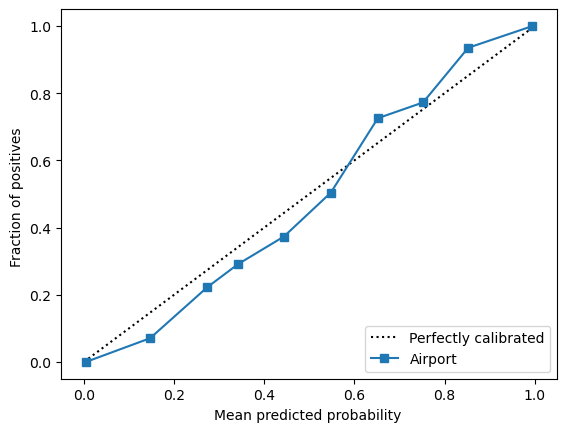

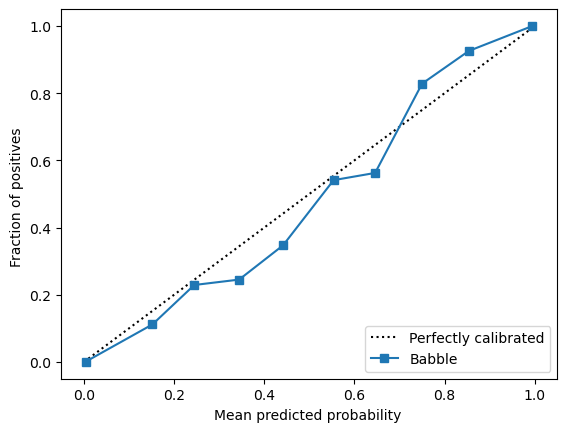

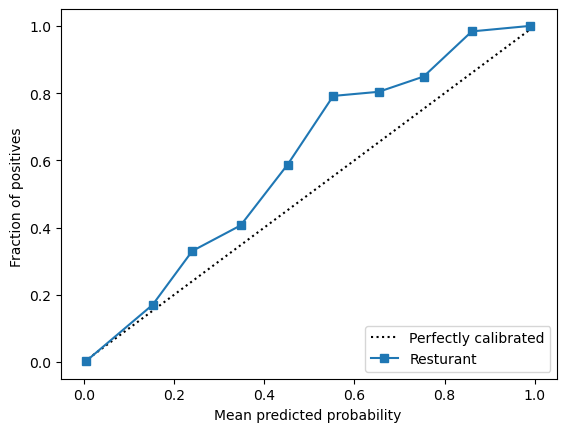

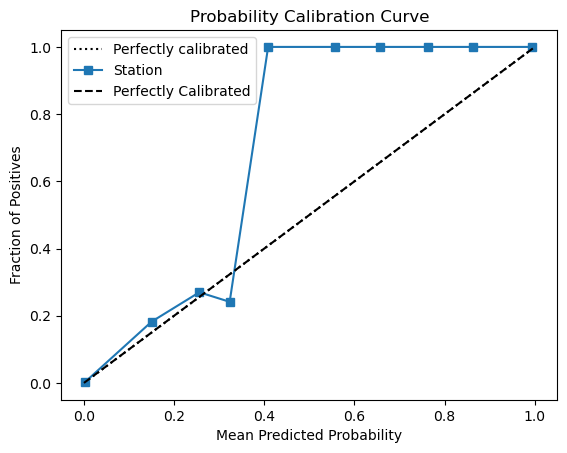

In [4]:
from sklearn.metrics import brier_score_loss
from sklearn.calibration import calibration_curve, CalibrationDisplay  # Correct import
import matplotlib.pyplot as plt
import numpy as np

# Load the best model
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

# Collect predicted probabilities and true labels
all_probs = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        probs = F.softmax(outputs, dim=1)  # Convert logits to probabilities
        all_probs.append(probs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Concatenate predictions and labels
all_probs = np.concatenate(all_probs, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Binarize the labels for multi-class Brier Score
n_classes = len(classes)
true_labels_binarized = label_binarize(all_labels, classes=range(n_classes))

# Calculate Brier Score for each class
brier_scores = []
for i in range(n_classes):
    brier_scores.append(brier_score_loss(true_labels_binarized[:, i], all_probs[:, i]))

# Print Brier Scores
print("Brier Scores for Each Class:")
for i, class_name in enumerate(classes.keys()):
    print(f"{class_name}: {brier_scores[i]:.4f}")

# Plot Probability Calibration Curve for each class
plt.figure(figsize=(10, 8))
for i, class_name in enumerate(classes.keys()):
    prob_true, prob_pred = calibration_curve(true_labels_binarized[:, i], all_probs[:, i], n_bins=10, strategy='uniform')
    CalibrationDisplay(prob_true, prob_pred, all_probs[:, i]).plot(label=class_name)

# Plot the ideal calibration line
plt.plot([0, 1], [0, 1], "k--", label="Perfectly Calibrated")

# Add labels and legend
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Probability Calibration Curve")
plt.legend(loc="upper left")
#plt.savefig("calibration_curve.png")  # Save the plot
plt.show()

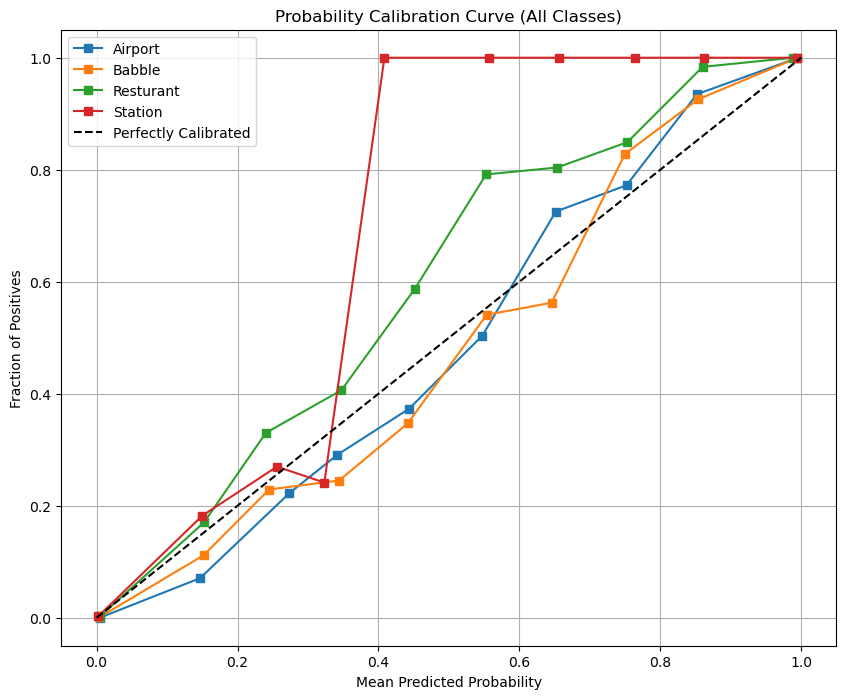

In [5]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import numpy as np

# Load the best model
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

# Collect predicted probabilities and true labels
all_probs = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        probs = F.softmax(outputs, dim=1)  # Convert logits to probabilities
        all_probs.append(probs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Concatenate predictions and labels
all_probs = np.concatenate(all_probs, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Binarize the labels for multi-class calibration
n_classes = len(classes)
true_labels_binarized = label_binarize(all_labels, classes=range(n_classes))

# Plot Probability Calibration Curve for all classes in one image
plt.figure(figsize=(10, 8))
for i, class_name in enumerate(classes.keys()):
    prob_true, prob_pred = calibration_curve(true_labels_binarized[:, i], all_probs[:, i], n_bins=10, strategy='uniform')
    plt.plot(prob_pred, prob_true, "s-", label=f"{class_name}")

# Plot the ideal calibration line
plt.plot([0, 1], [0, 1], "k--", label="Perfectly Calibrated")

# Add labels and legend
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Probability Calibration Curve (All Classes)")
plt.legend(loc="upper left")
plt.grid(True)
#plt.savefig("calibration_curve_all_classes.png")  # Save the plot
plt.show()

In [6]:
import os
import random
import torch
import torchaudio
import torchaudio.transforms as T
import numpy as np
from torch.utils.data import Dataset, DataLoader

# Load the trained model
model = PatchASTModel(num_classes=len(classes)).to(device)
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

# Define the preprocessing transform (same as during training)
mel_transform = T.MelSpectrogram(sample_rate=22050, n_fft=1024, hop_length=512, n_mels=128)
db_transform = T.AmplitudeToDB()

# Function to preprocess a single .wav file
def preprocess_audio(file_path, fixed_length=128):
    waveform, _ = torchaudio.load(file_path)
    mel_spec = mel_transform(waveform).squeeze(0)
    mel_spec = db_transform(mel_spec)  # Convert to dB scale
    mel_spec = torch.clamp(mel_spec, min=1e-5)
    mel_spec = torch.log1p(mel_spec)

    # Ensure consistent shape
    if mel_spec.shape[1] < fixed_length:
        mel_spec = F.pad(mel_spec, (0, fixed_length - mel_spec.shape[1]))
    else:
        mel_spec = mel_spec[:, :fixed_length]

    return mel_spec.unsqueeze(0)  # Add batch dimension

# Select 5 random .wav files from the test dataset
test_files = test_files  # Replace with your list of test file paths
random_files = random.sample(test_files, 20)

# Predict and display results
for file_path in random_files:
    # Preprocess the audio file
    input_tensor = preprocess_audio(file_path).to(device)
    
    # Make prediction
    with torch.no_grad():
        output = model(input_tensor)
        probabilities = F.softmax(output, dim=1)
        predicted_class = torch.argmax(probabilities).item()
    
    # Get the predicted class name
    predicted_class_name = list(classes.keys())[predicted_class]
    
    # Display the result
    print(f"File: {os.path.basename(file_path)}")
    print(f"Predicted Class: {predicted_class_name} (Confidence: {probabilities[0][predicted_class]:.4f})")
    print("-" * 50)

File: MKNKK09A010012I044_STATION_aug_1_dd51d0c6.wav
Predicted Class: Resturant (Confidence: 0.6838)
--------------------------------------------------
File: MKNKK09A010028I055_RESTURANT_aug_0_fefa815e.wav
Predicted Class: Airport (Confidence: 0.6573)
--------------------------------------------------
File: MKNKK09A010047I037_STATION_aug_1_f114c362.wav
Predicted Class: Resturant (Confidence: 0.8234)
--------------------------------------------------
File: MKNKK10A020001I013_AIRPORT_aug_1_43b3f4df.wav
Predicted Class: Resturant (Confidence: 0.7807)
--------------------------------------------------
File: MKNKK24A030050I020_AIRPORT_aug_1_1f6a88f8.wav
Predicted Class: Resturant (Confidence: 0.9771)
--------------------------------------------------
File: MKNKK24A040042I003_AIRPORT_aug_1_d05a3e5c.wav
Predicted Class: Resturant (Confidence: 0.8425)
--------------------------------------------------
File: FKNKK10A020009I004_AIRPORT_aug_1_e1901567.wav
Predicted Class: Resturant (Confidence: 0.

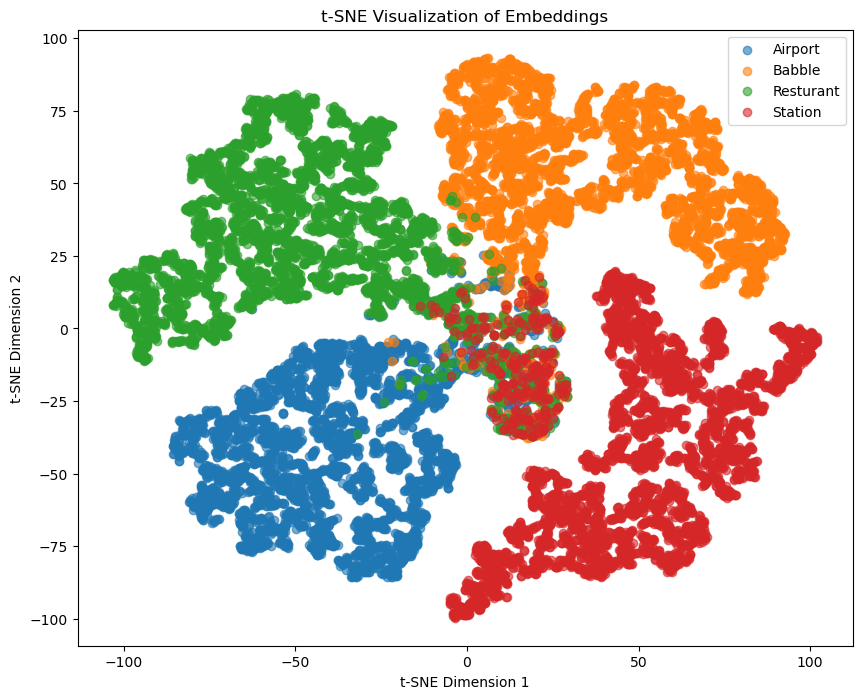

In [7]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Extract embeddings from the model (e.g., from the last layer before the classifier)
embeddings = []
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        embeddings.append(outputs.cpu().numpy())

embeddings = np.concatenate(embeddings, axis=0)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

# Plot embeddings
plt.figure(figsize=(10, 8))
for i, class_name in enumerate(classes.keys()):
    plt.scatter(embeddings_2d[all_labels == i, 0], embeddings_2d[all_labels == i, 1], label=class_name, alpha=0.6)
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.title("t-SNE Visualization of Embeddings")
plt.legend()
plt.savefig("tsne_embeddings.png")
plt.show()

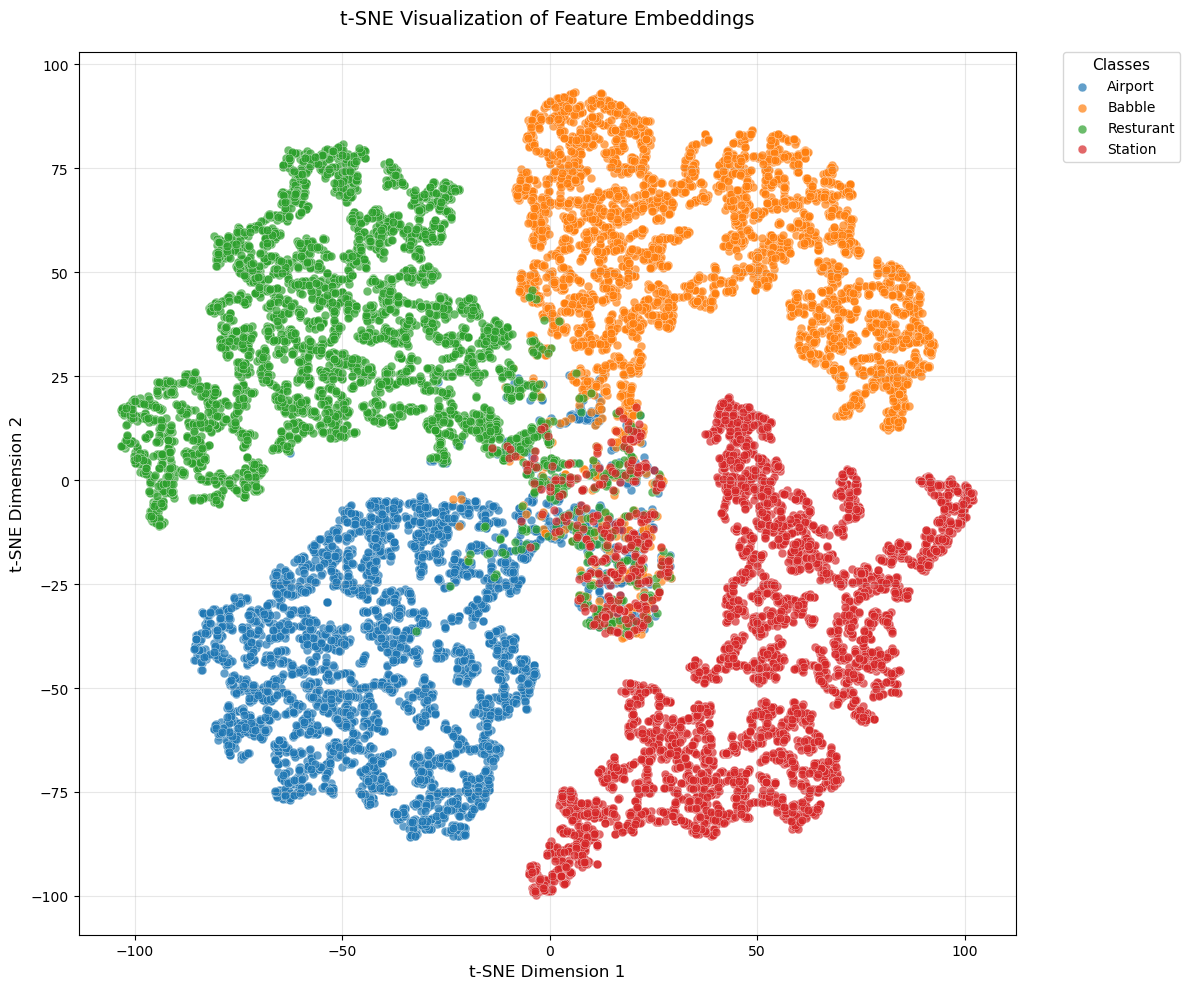

In [11]:
# t-SNE feature visualization (without cluster metrics)
plt.figure(figsize=(12, 10))

# Create a scatter plot for each class
for i, class_name in enumerate(classes.keys()):
    plt.scatter(
        embeddings_2d[all_labels == i, 0], 
        embeddings_2d[all_labels == i, 1], 
        label=class_name, 
        alpha=0.7,
        s=40,          # Marker size
        edgecolors='w', # White edges
        linewidth=0.3
    )

# Add labels and title
plt.xlabel("t-SNE Dimension 1", fontsize=12)
plt.ylabel("t-SNE Dimension 2", fontsize=12)
plt.title("t-SNE Visualization of Feature Embeddings", fontsize=14, pad=20)

# Add grid and legend
plt.grid(alpha=0.3)
plt.legend(
    bbox_to_anchor=(1.05, 1), 
    loc='upper left', 
    borderaxespad=0,
    fontsize=10,
    title='Classes',
    title_fontsize=11
)

# Adjust layout and save
plt.tight_layout()
plt.savefig("tsne_embeddings.png", dpi=300, bbox_inches='tight')
plt.show()

2025-04-27 03:40:05.368619: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-27 03:40:05.393444: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745705405.419875 2349088 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745705405.427747 2349088 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745705405.449245 2349088 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

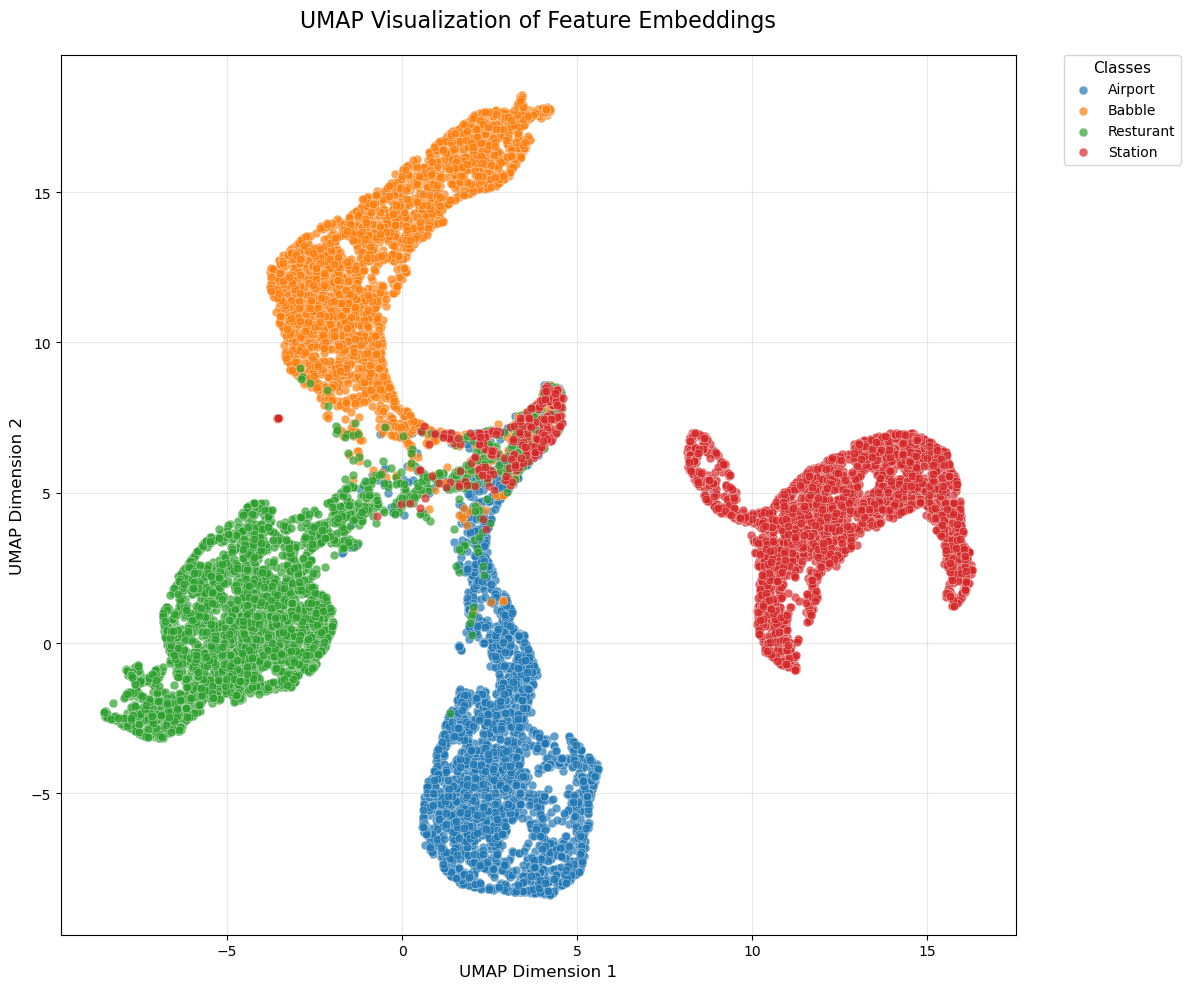

In [12]:
import matplotlib.pyplot as plt
from umap import UMAP

# Initialize and apply UMAP
umap_model = UMAP(
    n_components=2,
    n_neighbors=15,
    min_dist=0.1,
    random_state=42
)
embeddings_umap = umap_model.fit_transform(embeddings)

# Plotting UMAP embeddings
plt.figure(figsize=(12, 10))
for idx, class_name in enumerate(classes.keys()):
    plt.scatter(
        embeddings_umap[all_labels == idx, 0],
        embeddings_umap[all_labels == idx, 1],
        label=class_name,
        s=40,
        alpha=0.7,
        edgecolors='white',
        linewidth=0.3
    )

# Plot aesthetics
plt.xlabel("UMAP Dimension 1", fontsize=12)
plt.ylabel("UMAP Dimension 2", fontsize=12)
plt.title("UMAP Visualization of Feature Embeddings", fontsize=16, pad=20)
plt.grid(alpha=0.3)
plt.legend(
    title='Classes',
    title_fontsize=11,
    fontsize=10,
    loc='upper left',
    bbox_to_anchor=(1.05, 1),
    borderaxespad=0
)

# Save and display the plot
plt.tight_layout()
plt.savefig("umap_embeddings.png", dpi=300, bbox_inches='tight')
plt.show()



╔════════════════════════════╗
║    Class-wise Accuracy     ║
╠═══════════════╦════════════╣
║ Class         ║ Accuracy   ║
╠═══════════════╬════════════╣
║ Airport       ║   97.22% ║
║ Babble        ║   94.44% ║
║ Restaurant    ║   93.13% ║
║ Station       ║   93.56% ║
╚═══════════════╩════════════╝


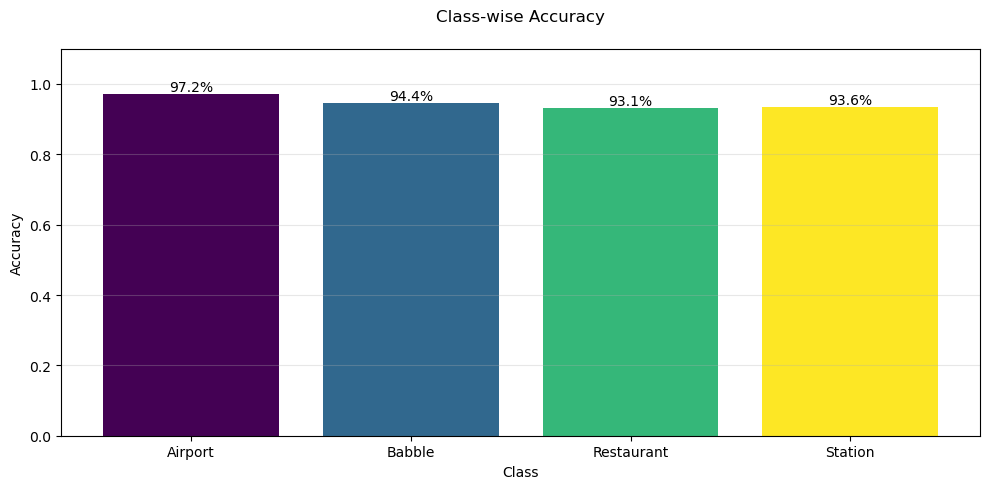

In [40]:
import matplotlib.pyplot as plt
import numpy as np

def plot_class_wise_accuracy(model, data_loader, classes):
    """Calculate, print, and plot class-wise accuracy"""
    model.eval()
    
    # Handle both list and dictionary formats for classes
    if isinstance(classes, dict):
        class_names = list(classes.keys())
        class_mapping = classes
    else:  # Assume it's a list
        class_names = [str(cls) for cls in classes]
        class_mapping = {name: idx for idx, name in enumerate(class_names)}
    
    correct = {class_name: 0 for class_name in class_names}
    total = {class_name: 0 for class_name in class_names}
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for label, pred in zip(labels, preds):
                class_name = class_names[label.item()]
                total[class_name] += 1
                if label.item() == pred.item():
                    correct[class_name] += 1
    
    # Calculate accuracies
    accuracies = {class_name: correct[class_name]/total[class_name] 
                 for class_name in class_names}
    
    # Print results in table format
    print("\n╔════════════════════════════╗")
    print("║    Class-wise Accuracy     ║")
    print("╠═══════════════╦════════════╣")
    print("║ Class         ║ Accuracy   ║")
    print("╠═══════════════╬════════════╣")
    for class_name, acc in accuracies.items():
        print(f"║ {class_name:<13} ║ {acc:>8.2%} ║")
    print("╚═══════════════╩════════════╝")
    
    # Plot results
    plt.figure(figsize=(10, 5))
    
    # Bar plot
    colors = plt.cm.viridis(np.linspace(0, 1, len(class_names)))
    bars = plt.bar(accuracies.keys(), accuracies.values(), color=colors)
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1%}', ha='center', va='bottom')
    
    # Formatting
    plt.title('Class-wise Accuracy', pad=20)
    plt.xlabel('Class')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1.1)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    
    # Save and show
    plt.savefig('class_wise_accuracy.png', dpi=300, bbox_inches='tight')
    plt.show()

# Example usage
model.load_state_dict(torch.load("best_model.pth"))
plot_class_wise_accuracy(model, test_loader, classes)

In [48]:
def calculate_snr_class_accuracy(model, data_loader, snr_folders, classes):
    """Calculate accuracy for each SNR level and class"""
    model.eval()
    
    # Handle both list and dictionary formats for classes
    if isinstance(classes, dict):
        class_names = list(classes.keys())
    else:  # Assume it's a list
        class_names = [str(cls) for cls in classes]
    
    # Initialize results dictionary
    results = {snr: {class_name: {'correct': 0, 'total': 0} 
              for class_name in class_names} 
              for snr in snr_folders}
    
    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(data_loader):
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            # Get file paths for this batch
            start_idx = batch_idx * data_loader.batch_size
            batch_files = data_loader.dataset.file_list[start_idx:start_idx+len(labels)]
            
            for i in range(len(labels)):
                file_path = batch_files[i]
                snr = file_path.split('/')[-2]
                class_idx = labels[i].item()
                class_name = class_names[class_idx]
                
                results[snr][class_name]['total'] += 1
                if predicted[i] == labels[i]:
                    results[snr][class_name]['correct'] += 1
    
    # Convert to accuracy percentages
    accuracy_dict = {}
    for snr in snr_folders:
        accuracy_dict[snr] = {}
        for class_name in class_names:
            total = results[snr][class_name]['total']
            correct = results[snr][class_name]['correct']
            accuracy_dict[snr][class_name] = correct / total if total > 0 else 0
    
    return accuracy_dict

def print_snr_class_accuracy(accuracy_dict):
    """Print SNR-wise accuracy for each class in table format"""
    # Create DataFrame for printing
    df = pd.DataFrame.from_dict(accuracy_dict, orient='index')
    
    print("\nSNR-wise Accuracy per Class:")
    print("-" * (15 + 12*len(df.columns)))
    print(f"{'SNR':<10}", end="")
    for class_name in df.columns:
        print(f"| {class_name[:10]:>10}", end="")
    print("\n" + "-" * (15 + 12*len(df.columns)))
    
    for snr in sorted(df.index, key=lambda x: int(x.split('_')[-1])):
        print(f"{snr:<10}", end="")
        for class_name in df.columns:
            print(f"| {df.loc[snr, class_name]:>10.2%}", end="")
        print()
    print("-" * (15 + 12*len(df.columns)))

# Example usage with list format classes
classes = ['Airport', 'Babble', 'Restaurant', 'Station']  # Can be list or dict
snr_folders = ['SNR_-5', 'SNR_-3', 'SNR_0', 'SNR_3', 'SNR_5', 'SNR_10']

model.load_state_dict(torch.load("best_model.pth"))
accuracy_results = calculate_snr_class_accuracy(model, test_loader, snr_folders, classes)
print_snr_class_accuracy(accuracy_results)


SNR-wise Accuracy per Class:
---------------------------------------------------------------
SNR       |    Airport|     Babble| Restaurant|    Station
---------------------------------------------------------------
SNR_-5    |    100.00%|     99.46%|     98.83%|     98.80%
SNR_-3    |     99.57%|     99.04%|     98.60%|     98.81%
SNR_0     |     98.56%|     97.75%|     96.20%|     97.27%
SNR_3     |     97.32%|     95.14%|     93.28%|     93.69%
SNR_5     |     97.00%|     91.04%|     92.89%|     92.07%
SNR_10    |     90.91%|     84.75%|     79.14%|     81.04%
---------------------------------------------------------------


In [56]:
def calculate_snr_class_accuracy(model, data_loader, snr_folders, classes):
    """Calculate accuracy for each SNR level and class"""
    model.eval()
    
    # Handle both list and dictionary formats for classes
    if isinstance(classes, dict):
        class_names = list(classes.keys())
    else:  # Assume it's a list
        class_names = [str(cls) for cls in classes]
    
    # Initialize results dictionary
    results = {snr: {class_name: {'correct': 0, 'total': 0} 
              for class_name in class_names} 
              for snr in snr_folders}
    
    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(data_loader):
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            # Get file paths for this batch
            start_idx = batch_idx * data_loader.batch_size
            batch_files = data_loader.dataset.file_list[start_idx:start_idx+len(labels)]
            
            for i in range(len(labels)):
                file_path = batch_files[i]
                snr = file_path.split('/')[-2]
                class_idx = labels[i].item()
                class_name = class_names[class_idx]
                
                results[snr][class_name]['total'] += 1
                if predicted[i] == labels[i]:
                    results[snr][class_name]['correct'] += 1
    
    # Convert to accuracy percentages
    accuracy_dict = {}
    for snr in snr_folders:
        accuracy_dict[snr] = {}
        for class_name in class_names:
            total = results[snr][class_name]['total']
            correct = results[snr][class_name]['correct']
            accuracy_dict[snr][class_name] = correct / total if total > 0 else 0
    
    return accuracy_dict

def print_snr_statistics(accuracy_dict):
    """Print min/max/avg accuracy for each SNR level"""
    print("\nSNR Performance Statistics:")
    print("┌────────────┬────────────┬────────────┬────────────┬────────────┐")
    print("│ SNR (dB)   │ Min Acc    │ Max Acc    │ Avg Acc    │ Std Dev    │")
    print("├────────────┼────────────┼────────────┼────────────┼────────────┤")
    
    for snr in sorted(accuracy_dict.keys(), key=lambda x: int(x.split('_')[-1])):
        accuracies = list(accuracy_dict[snr].values())
        min_acc = min(accuracies)
        max_acc = max(accuracies)
        avg_acc = sum(accuracies)/len(accuracies)
        std_dev = (sum((x - avg_acc)**2 for x in accuracies)/len(accuracies))**0.5
        
        print(f"│ {snr:<10} │ {min_acc:>8.2%}  │ {max_acc:>8.2%}  │ {avg_acc:>8.2%}  │ {std_dev:>8.2%}  │")
    
    print("└────────────┴────────────┴────────────┴────────────┴────────────┘")

def print_class_ranking(accuracy_dict):
    """Print classes ranked by their robustness to noise"""
    # Calculate average accuracy drop from highest to lowest SNR
    class_stats = {}
    for class_name in list(accuracy_dict.values())[0].keys():
        acc_values = [accuracy_dict[snr][class_name] for snr in sorted(
            accuracy_dict.keys(), 
            key=lambda x: int(x.split('_')[-1])
        )]
        drop = acc_values[0] - acc_values[-1]  # Highest SNR - Lowest SNR
        class_stats[class_name] = {
            'max_acc': max(acc_values),
            'min_acc': min(acc_values),
            'drop': drop,
            'avg_acc': sum(acc_values)/len(acc_values)
        }
    
    # Sort by performance drop (most robust first)
    sorted_classes = sorted(class_stats.items(), key=lambda x: x[1]['drop'])
    
    print("\nClass Robustness Ranking (most robust first):")
    print("┌────────────┬────────────┬────────────┬────────────┬────────────┐")
    print("│ Class      │ Max Acc    │ Min Acc    │ Avg Acc    │ Drop       │")
    print("├────────────┼────────────┼────────────┼────────────┼────────────┤")
    
    for class_name, stats in sorted_classes:
        print(f"│ {class_name:<10} │ {stats['max_acc']:>8.2%}  │ {stats['min_acc']:>8.2%}  │ {stats['avg_acc']:>8.2%}  │ {stats['drop']:>8.2%}  │")
    
    print("└────────────┴────────────┴────────────┴────────────┴────────────┘")

def print_critical_snrs(accuracy_dict, threshold=0.85):
    """Print when each class crosses accuracy threshold"""
    print(f"\nCritical SNR Levels ({threshold:.0%} Accuracy Threshold):")
    print("┌────────────┬───────────────────────┬───────────────────────┐")
    print("│ Class      │ Critical SNR (dB)     │ Accuracy at Critical  │")
    print("├────────────┼───────────────────────┼───────────────────────┤")
    
    for class_name in list(accuracy_dict.values())[0].keys():
        # Get SNRs sorted from worst to best
        snrs = sorted(accuracy_dict.keys(), 
                     key=lambda x: int(x.split('_')[-1]))
        
        for snr in snrs:
            if accuracy_dict[snr][class_name] >= threshold:
                print(f"│ {class_name:<10} │ {snr:>15}      │ {accuracy_dict[snr][class_name]:>19.2%}  │")
                break
        else:
            print(f"│ {class_name:<10} │ {'Never':>15}      │ {'N/A':>19}  │")
    
    print("└────────────┴───────────────────────┴───────────────────────┘")

# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define your classes (either list or dictionary format)
classes = ['Airport', 'Babble', 'Restaurant', 'Station']  # List format
# OR: classes = {'Airport': 0, 'Babble': 1, 'Restaurant': 2, 'Station': 3}  # Dict format

# Define your SNR folders
snr_folders = ['SNR_-5', 'SNR_-3', 'SNR_0', 'SNR_3', 'SNR_5', 'SNR_10']

# Load your trained model
model = PatchASTModel(num_classes=len(classes)).to(device)
model.load_state_dict(torch.load("best_model.pth"))

# Calculate results
accuracy_results = calculate_snr_class_accuracy(model, test_loader, snr_folders, classes)

# Print all analyses
print_snr_statistics(accuracy_results)
print_class_ranking(accuracy_results)
print_critical_snrs(accuracy_results, threshold=0.95)  # Change threshold as needed


SNR Performance Statistics:
┌────────────┬────────────┬────────────┬────────────┬────────────┐
│ SNR (dB)   │ Min Acc    │ Max Acc    │ Avg Acc    │ Std Dev    │
├────────────┼────────────┼────────────┼────────────┼────────────┤
│ SNR_-5     │   98.80%  │  100.00%  │   99.27%  │    0.50%  │
│ SNR_-3     │   98.60%  │   99.57%  │   99.00%  │    0.36%  │
│ SNR_0      │   96.20%  │   98.56%  │   97.44%  │    0.86%  │
│ SNR_3      │   93.28%  │   97.32%  │   94.86%  │    1.58%  │
│ SNR_5      │   91.04%  │   97.00%  │   93.25%  │    2.26%  │
│ SNR_10     │   79.14%  │   90.91%  │   83.96%  │    4.49%  │
└────────────┴────────────┴────────────┴────────────┴────────────┘

Class Robustness Ranking (most robust first):
┌────────────┬────────────┬────────────┬────────────┬────────────┐
│ Class      │ Max Acc    │ Min Acc    │ Avg Acc    │ Drop       │
├────────────┼────────────┼────────────┼────────────┼────────────┤
│ Airport    │  100.00%  │   90.91%  │   97.23%  │    9.09%  │
│ Babble     │

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
try:
    from torchinfo import summary
except ImportError:
    print("Error: 'torchinfo' is not installed. Please install it with 'pip install torchinfo'.")
    exit(1)

# PatchAST Model Definition
class PatchASTModel(nn.Module):
    def __init__(self, num_classes=4, embed_dim=512, num_heads=4, num_layers=6, dropout=0.2):
        super().__init__()
        self.patch_embedding = nn.Linear(128, embed_dim)
        self.batch_norm = nn.BatchNorm1d(128, eps=1e-5)
        self.positional_encoding = nn.Parameter(torch.zeros(1, 128, embed_dim))
        self.dropout = nn.Dropout(dropout)
        self.transformer_layers = nn.ModuleList([
            nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, batch_first=True)
            for _ in range(num_layers)
        ])
        self.layer_norm = nn.LayerNorm(embed_dim)
        self.attention_pooling = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout)
        self.fc = nn.Linear(embed_dim, num_classes)
        
        # Xavier Initialization
        nn.init.xavier_uniform_(self.patch_embedding.weight)
        nn.init.zeros_(self.patch_embedding.bias)
        nn.init.xavier_uniform_(self.fc.weight)
        nn.init.zeros_(self.fc.bias)
    
    def forward(self, x):
        x = x.permute(0, 2, 1)  # (batch, 128, time) -> (batch, time, 128)
        x = self.patch_embedding(x)
        x = self.batch_norm(x)
        x = F.gelu(x)  # Apply GeLU after batch normalization
        x = x + self.positional_encoding[:, :x.size(1), :]
        x = self.dropout(x)
        
        for layer in self.transformer_layers:
            x = layer(x)
            x = self.layer_norm(x)  # Layer normalization before activation
        
        # Attention Pooling
        x = x.permute(1, 0, 2)  # (batch, time, embed) -> (time, batch, embed)
        x, _ = self.attention_pooling(x, x, x)
        x = x.mean(dim=0)  # Global average pooling
        
        return self.fc(x)  # Final classification

# Main block to print model summary
if __name__ == "__main__":
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Initialize the model
    try:
        model = PatchASTModel(
            num_classes=4,       # Number of output classes
            embed_dim=512,       # Embedding dimension
            num_heads=4,         # Number of attention heads
            num_layers=6,        # Number of transformer layers
            dropout=0.2          # Dropout rate
        ).to(device)
    except Exception as e:
        print(f"Error initializing model: {e}")
        exit(1)
    
    # Print model summary
    print("PatchAST Model Summary:")
    try:
        # Capture summary as a string and print it explicitly
        summary_str = summary(model, input_size=(1, 128, 128), device=device, verbose=0)
        print(summary_str)
    except Exception as e:
        print(f"Error generating summary: {e}")

Using device: cuda
PatchAST Model Summary:
Layer (type:depth-idx)                   Output Shape              Param #
PatchASTModel                            [1, 4]                    65,536
├─Linear: 1-1                            [1, 128, 512]             66,048
├─BatchNorm1d: 1-2                       [1, 128, 512]             256
├─Dropout: 1-3                           [1, 128, 512]             --
├─ModuleList: 1-14                       --                        (recursive)
│    └─TransformerEncoderLayer: 2-1      [1, 128, 512]             --
│    │    └─MultiheadAttention: 3-1      [1, 128, 512]             1,050,624
│    │    └─Dropout: 3-2                 [1, 128, 512]             --
│    │    └─LayerNorm: 3-3               [1, 128, 512]             1,024
│    │    └─Linear: 3-4                  [1, 128, 2048]            1,050,624
│    │    └─Dropout: 3-5                 [1, 128, 2048]            --
│    │    └─Linear: 3-6                  [1, 128, 512]             1,049,088
